In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata

import xarray as xr
import rioxarray as rxr
from pyproj import Proj, Transformer, CRS

In [2]:
## LOAD GRID AND GET COORDINATE LOCATIONS
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)

grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)

crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)

grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

In [3]:
# Data collection area
# Currently bounded by:
# Lat 42° S, 18° N
# Long 6° E, 80° E

In [4]:
# List of variables: PP, SPM, no3
variable = 'no3'
download = True

if download:
    if variable == 'PP':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS \
            --product-id dataset-oc-glo-bio-multi-l4-pp_4km_monthly-rep \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable PP \
            --out-name CMEMS_dataset.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'SPM':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-spm_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable SPM \
            --out-name CMEMS_dataset.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'ZSD':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-zsd_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable ZSD \
            --out-name CMEMS_dataset.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'Nutrients':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id GLOBAL_REANALYSIS_BIO_001_029-TDS \
            --product-id global-reanalysis-bio-001-029-monthly \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --depth-min 0 --depth-max 50 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable no3 \
            --out-name CMEMS_dataset.nc --user bqueste1 --pwd @nrIm10liv@

In [5]:
## LOAD UP CMEMS DATA FILE
data = xr.open_dataset('CMEMS_dataset.nc')
data

<xarray.Dataset>
Dimensions:    (depth: 18, latitude: 245, longitude: 301, time: 59)
Coordinates:
  * depth      (depth) float32 0.5058 1.556 2.668 3.856 ... 35.74 41.18 47.21
  * latitude   (latitude) float32 -42.5 -42.25 -42.0 -41.75 ... 18.0 18.25 18.5
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2019-11-15T23:56:15
  * longitude  (longitude) float32 5.5 5.75 6.0 6.25 ... 79.75 80.0 80.25 80.5
Data variables:
    no3        (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    product:                       GLOBAL_REANALYSIS_BIO_001_029
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         Monthly mean fields for product GLOBAL_REA...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    dataset:                       global-reanalysis-bio-001-029-monthly
    institution:                   Mercator Ocean
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [6]:
if 'depth' in data.dims:
    data = data.mean(dim='depth')

In [7]:
# Average months together first, then by season, then by year to limit impact of reduced data at certain times of year-
month_length = data.time.dt.days_in_month

# Calculate the weights by grouping by 'time.month'.
weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

# Calculate the weighted average
clim = (data * weights).groupby('time.month').sum(dim='time')

In [8]:
# Now do climatological average
out = clim.mean(dim='month')

In [9]:
if 'lon' in data.dims:
    lons, lats = np.meshgrid(out.lon.values,out.lat.values) 
    valid = np.isfinite(out[variable].values.flatten())
if 'longitude' in data.dims:
    lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
    valid = np.isfinite(out[variable].values.flatten())

In [10]:
raster = griddata((lons.flatten()[valid], lats.flatten()[valid]), out[variable].values.flatten()[valid] , (grid_lon, grid_lat))

In [11]:
grid1km.values = grid1km.values*raster

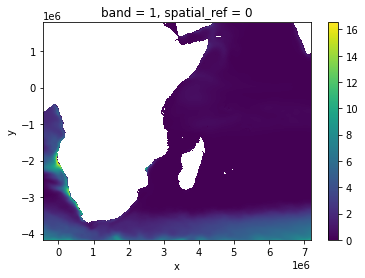

In [12]:
grid1km.plot()

In [13]:
grid1km.rio.to_raster("grid_1km_"+variable+"_byq.tif")

In [14]:
data

<xarray.Dataset>
Dimensions:    (latitude: 245, longitude: 301, time: 59)
Coordinates:
  * latitude   (latitude) float32 -42.5 -42.25 -42.0 -41.75 ... 18.0 18.25 18.5
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2019-11-15T23:56:15
  * longitude  (longitude) float32 5.5 5.75 6.0 6.25 ... 79.75 80.0 80.25 80.5
Data variables:
    no3        (time, latitude, longitude) float32 13.97 14.16 14.32 ... nan nan